In [1]:
import os
import xarray as xr
import sys
import itertools
from itertools import zip_longest
from lca_algebraic import initProject
import pandas as pd
import numpy as np
import xarray as xr
import lca_algebraic as agb
from lca_algebraic import *
from lca_algebraic.stats import * 
import bw2data, bw2io
import bw2calc
from premise import *
import premise as prm
from scipy.integrate import cumtrapz

In [2]:
sys.path.append('/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/') 
from utils import *
from utils.setup import *
from utils.setup_whdLCIA import *
from utils.getAct import *
from utils.utils import *
from utils.dlcia_functions import *

modify the setup.py file for reading Parameter excel sheet. here we use 'data/p_file/p_tech_perSSP_Y.xlsx' as the technology parameter file.  
Define your chosen methods in the setup.py file. Current methods are:  [('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')]
Mapping premise_remind_DB to SSPx:  {'SSP1-PkBudg500': 'ssp119', 'SSP1-PkBudg1150': 'ssp126', 'SSP2-Base': 'ssp245', 'SSP5-Base': 'ssp585'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pGWP100 are imported as:  [('IPCC 2021 - dpCFsSSP119_MY2030 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP245_MY2030 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP585_MY2030 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP119_MY2040 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP245_MY2040 - year100', 'climate cha

In [3]:
bw2data.projects.set_current('iveo_v1')
mybio = bw2data.Database("biosphere3")
initProject("iveo_v1")

Biosphere database already present!!! No setup is needed


In [4]:
print( ssp_scn  , ssp_yr) 
bw2_method_metric = 'dpIRF'

root_path = '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/'
tech_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/p_tech_perSSP_Y.xlsx'))
consmp_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/tech_conversion_veh_p/p_scn_v_need_tech.xlsx'))

['_remind_SSP1-PkBudg500', '_remind_SSP2-Base', '_remind_SSP5-Base'] [2030, 2040, 2050]


In [5]:
v_lifetime = 20  
b_lifetime = 10 

### init 

In [6]:
pdb = bw.Database("iveo_Parameterized_v1")
print(len(pdb))
agb.loadParams()

384


[ParamRegistry] Param NMC622_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param NCA_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LFP_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LTO_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_NG_MJperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_elec_kWhperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param g_truck_vehicle_prod_lightweighting was already defined in '<project>' : overriding.
[ParamRegistry] Param battery_total_capacity_for_gtruck was already defined in '<project>' : overriding.
[ParamRegistry] Param biodiesel_UCO_perc was already defined in '<project>' : overriding.
[ParamRegistry] Pa

In [7]:
#agb.list_parameters()

### get already created UPRs:

In [8]:
bat_finalwhbat_switch_allsspyear = [] 

for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        bg_db_ssp_yr = bg_ei_ + prm_name + "_" + str(year_t)            # backgroun database (BD) to use for SSP[x], Year[t]
        copied_prm_UPR_suffix = "_from_" + prm_name + "_" + str(year_t) # copy UPR from BD to PDB for further use/modification if needed
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t)          # naming on any new UPRs created in PDB

        # final one unit of g_truck with lightweighting as Parameter: 
        bat_final_whbatswitch = agb.findActivity(
                db_name = PDB_NAME,
                name="V1B_bat_g-truck BEV_wh_switch_bat" + newUPR_suffix)

        bat_finalwhbat_switch_allsspyear.append(bat_final_whbatswitch)


len(bat_finalwhbat_switch_allsspyear)

9

#### read in TRL table to see which switch_P to apply

In [9]:
data = xr.open_dataset( os.path.abspath(os.path.join(root_path, 'data/to_use_interm/TRL_1C_vehDSwhTRL.nc')))
data2 = data.where(data["tech_avail"] == 1, drop = True) 
data2

<xarray.Dataset>
Dimensions:     (v_type: 1, size: 1, powertrain: 2, v_year: 3, SSP: 4,
                 Module: 5, Tech: 9)
Coordinates:
  * Tech        (Tech) object 'LIB_LFP' 'LIB_LTO' ... 'dummy_tech' 'grid_elec'
  * Module      (Module) object 'F2_fuel_diesel' 'F2_fuel_elec' ... 'V2_oper'
  * SSP         (SSP) object 'ssp119' 'ssp126' 'ssp245' 'ssp585'
  * v_year      (v_year) int32 2030 2040 2050
  * powertrain  (powertrain) object 'BEV' 'ICEV-d'
  * v_type      (v_type) object 'garbage_truck'
  * size        (size) object 'HDV_class7'
Data variables:
    TRL         (v_type, size, powertrain, v_year, SSP, Module, Tech) float64 ...
    tech_appl   (v_type, size, powertrain, v_year, SSP, Module, Tech) float64 ...
    tech_avail  (v_type, size, powertrain, v_year, SSP, Module, Tech) float64 ...

#### C.B.0 read all P file 

In [10]:
for bat_final_whSwitchbat in bat_finalwhbat_switch_allsspyear:
    print(bat_final_whSwitchbat)
    # need a matched YearlyParams for each SSPx:
    str1 = bat_final_whSwitchbat.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)

    """ for each LCI scenario, using a respective SSP[x] as the dLCIA method """ 
    chosen_methods_perssp = get_my_dpLCIA(ssp = ssp_to_get_inP, my = year_to_get_inP, metric = bw2_method_metric ) 
    yearlyParams = loadYearlyParams_multisheet(PARAMS_FILE = tech_p_file, s_name = ['V1A_g_truck', 'V1B_bat_LSB_perkWh', 'V1B_bat_prmLIBs_perkWh'], years = [year_to_get_inP], SSP = ssp_to_get_inP) 
    #print(f"for SSP {ssp_to_get_inP}, year {year_to_get_inP}, P:  {yearlyParams}" )


'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2030' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 119, MY2030 is, for example for year 30,: ('IPCC 2021 - dpCFsSSP119_MY2030 - year30', 'climate change', 'dpIRF30'), total len: 101  
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2040' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 119, MY2040 is, for example for year 16,: ('IPCC 2021 - dpCFsSSP119_MY2040 - year16', 'climate change', 'dpIRF16'), total len: 101  
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2050' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 119, MY2050 is, for example for year 27,: ('IPCC 2021 - dpCFsSSP119_MY2050 - year27', 'climate change', 'dpIRF27'), total len: 101  
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2030' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 245, MY2030 is, for example for year 14,: ('IPCC 2021 - dpCFsSSP245_MY2030 - year14', 'climate change', 'dpIRF14'), total 

#### C.B.1   TBD::   run bat_replacement with : IPCCGWP100,  premiseGWP, pGWP100_per_premiseGWP

#### C.B.2  final V1B calc <font color = 'red'> bat_replacement impacts at Year[b_replace] </font>

In [11]:
v_lifetime = 20  
b_lifetime = 10 
""" assuming replacing battery once at Year[10], to make it simplifed, real-life battery_lifetime is around 8 years, 
    in that case, need to adjust the v_lifetime for BEV to 16 years, as it's unlikely ppl will invest a 3rd battery 
""" 
GWP_list, SSP_list, Year_list, tech_list, run_Y_list  = [], [],[], [], []

""" first loop is for each v_year:: [year_to_get_inP] and SSP:: [ssp_to_get_inP]""" 
""" only run battery impacts, w/o initial vehicle impacts """
for bat_final_whSwitchbat in bat_finalwhbat_switch_allsspyear:
    print(bat_final_whSwitchbat)
    # need a matched YearlyParams for each SSPx:
    str1 = bat_final_whSwitchbat.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)

    """ for each LCI scenario, using a respective SSP[x] as the dLCIA method """ 
    chosen_methods_perssp = get_my_dpLCIA(ssp = ssp_to_get_inP, my = year_to_get_inP, metric = bw2_method_metric ) 
    yearlyParams = loadYearlyParams_multisheet(PARAMS_FILE = tech_p_file, s_name = ['V1A_g_truck', 'V1B_bat_LSB_perkWh', 'V1B_bat_prmLIBs_perkWh'], years = [year_to_get_inP], SSP = ssp_to_get_inP) 
     
    """ see what tech can be used under SSPx, Yeart, then addin another layer of for loop for selecting applicable tech  
    """
    year_to_get_inP_Yof_bat_repl = year_to_get_inP + b_lifetime
    #print(year_to_get_inP_Yof_bat_repl) # for a v_year 2050, you'll have future bat_year e.g., 2060 that's not within the .ds 
    if year_to_get_inP_Yof_bat_repl <= 2050: 
        year_to_get_inP_Yof_bat_repl2 = year_to_get_inP_Yof_bat_repl 
    else: 
        year_to_get_inP_Yof_bat_repl2 = 2050 
    
    all_app_bat, all_app_tech , all_app_bat = []  , [] , [] 
    
    for bat_x in ["LIB_NMC622",  'LIB_LFP',  'LIB_LTO', 'LIB_NCA', "LSB"]:
        bat_avail = data2.sel(Tech = bat_x, powertrain = "BEV", Module = "V1B", v_type = "garbage_truck",  
                              SSP = ssp_to_get_inP, v_year = year_to_get_inP_Yof_bat_repl2)["tech_avail"].values
        if np.isnan(bat_avail).all(): 
            pass
        else: 
            all_app_bat.append(bat_x)
    print(f" @@@@@@ for SSP {ssp_to_get_inP}, v_year {year_to_get_inP}, year_of_bat_replace {year_to_get_inP_Yof_bat_repl}, to read bat_parameters, assuming year {year_to_get_inP_Yof_bat_repl2}, available {all_app_bat}")

    #### nameing problems in data2.nc, to be updated
    for b_tech in all_app_bat :
        if b_tech == "LIB_NMC622":       
            b_tech = "NMC622"
        elif b_tech == "LIB_LFP":
            b_tech = "LFP"
        elif b_tech == "LIB_LTO":
            b_tech = "LTO"
        elif b_tech == "LIB_NCA": 
            b_tech = "NCA"
        
        run_Y_GWP_list,run_Y_SSP_list, run_Y_Year_list, run_Y_tech_list, run_Y = [],[],[],[],[] 
        """ for the specific bat_replace year, only run one year impact  """         
        for Y in range(year_to_get_inP_Yof_bat_repl2, year_to_get_inP_Yof_bat_repl2 + 1 ):      
            df= agb.multiLCAAlgebric(models=[
                (bat_final_whSwitchbat, 1)],   
                methods = chosen_methods_perssp,   
                #define switch parameter here if you have one, 
                gtruck_BEV_battery_tech = b_tech ,
                **yearlyParams
            )
            #print(f"end of running LCA calc for SSP {ssp_to_get_inP} and year {year_to_get_inP} using battery tech {b_tech} for {gtruck_final_whSwitchbat} ")
            display(df) 
            
            """ to have all 100 years run for dynamic LCIA """ 
            lcia_allyears = [] 
            for t in range(len(df.columns)): 
                lcia_t = df.iloc[:,t].values[0]
                lcia_allyears.append(lcia_t)
            
            run_Y_GWP_list.append(lcia_allyears)
            run_Y_SSP_list.append(ssp_to_get_inP) 
            run_Y_Year_list.append(year_to_get_inP)
            run_Y_tech_list.append(b_tech)
            run_Y.append(Y)
            print(len(run_Y_GWP_list),len(run_Y_SSP_list),len(run_Y_Year_list),len(run_Y_tech_list),len(run_Y))
        
        GWP_list.append(run_Y_GWP_list)
        SSP_list.append(run_Y_SSP_list) 
        Year_list.append(run_Y_Year_list)
        tech_list.append(run_Y_tech_list)        
        run_Y_list.append(run_Y) 


'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2030' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 119, MY2030 is, for example for year 3,: ('IPCC 2021 - dpCFsSSP119_MY2030 - year3', 'climate change', 'dpIRF3'), total len: 101  
 @@@@@@ for SSP ssp119, v_year 2030, year_of_bat_replace 2040, to read bat_parameters, assuming year 2040, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA', 'LSB']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2030,2.064476e-10,1.918201e-10,1.793434e-10,1.686166e-10,1.593212e-10,1.512075e-10,1.440605e-10,1.377436e-10,1.320896e-10,1.270470e-10,...,5.600303e-11,5.584923e-11,5.569803e-11,5.554951e-11,5.540345e-11,5.526025e-11,5.511940e-11,5.498096e-11,5.484483e-11,5.471096e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2030,1.735425e-10,1.613205e-10,1.509309e-10,1.420289e-10,1.343409e-10,1.276519e-10,1.217785e-10,1.166014e-10,1.119803e-10,1.078669e-10,...,4.917895e-11,4.904500e-11,4.891333e-11,4.878397e-11,4.865676e-11,4.853200e-11,4.840927e-11,4.828863e-11,4.817000e-11,4.805333e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2030,2.481434e-10,2.307405e-10,2.159759e-10,2.033508e-10,1.924691e-10,1.830197e-10,1.747379e-10,1.674498e-10,1.609552e-10,1.551805e-10,...,7.208624e-11,7.189018e-11,7.169743e-11,7.150804e-11,7.132179e-11,7.113909e-11,7.095936e-11,7.078268e-11,7.060892e-11,7.043801e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2030,1.827824e-10,1.699327e-10,1.590130e-10,1.496596e-10,1.415841e-10,1.345601e-10,1.283940e-10,1.229602e-10,1.181111e-10,1.137952e-10,...,5.203716e-11,5.189469e-11,5.175463e-11,5.161700e-11,5.148165e-11,5.134888e-11,5.121829e-11,5.108991e-11,5.096365e-11,5.083947e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2030,1.580656e-10,1.468853e-10,1.373608e-10,1.291825e-10,1.221043e-10,1.159334e-10,1.105039e-10,1.057100e-10,1.014235e-10,9.760326e-11,...,4.357246e-11,4.345348e-11,4.333652e-11,4.322163e-11,4.310865e-11,4.299787e-11,4.288890e-11,4.278180e-11,4.267648e-11,4.257292e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2040' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 119, MY2040 is, for example for year 3,: ('IPCC 2021 - dpCFsSSP119_MY2040 - year3', 'climate change', 'dpIRF3'), total len: 101  
 @@@@@@ for SSP ssp119, v_year 2040, year_of_bat_replace 2050, to read bat_parameters, assuming year 2050, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA', 'LSB']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2040,1.583870e-10,1.471880e-10,1.376304e-10,1.293986e-10,1.222389e-10,1.159735e-10,1.104776e-10,1.055945e-10,1.012407e-10,9.733330e-11,...,4.217211e-11,4.205576e-11,4.194155e-11,4.182942e-11,4.171931e-11,4.161119e-11,4.150488e-11,4.140044e-11,4.129773e-11,4.119675e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2040,1.329471e-10,1.236012e-10,1.156520e-10,1.088292e-10,1.029162e-10,9.775901e-11,9.324814e-11,8.925200e-11,8.569789e-11,8.251526e-11,...,3.703649e-11,3.693521e-11,3.683577e-11,3.673813e-11,3.664223e-11,3.654804e-11,3.645543e-11,3.636443e-11,3.627493e-11,3.618693e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2040,1.899306e-10,1.766324e-10,1.653439e-10,1.556750e-10,1.473130e-10,1.400343e-10,1.336786e-10,1.280580e-10,1.230666e-10,1.186028e-10,...,5.428883e-11,5.414062e-11,5.399508e-11,5.385217e-11,5.371178e-11,5.357388e-11,5.343829e-11,5.330503e-11,5.317397e-11,5.304508e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2040,1.399996e-10,1.301749e-10,1.218210e-10,1.146532e-10,1.084431e-10,1.030284e-10,9.829338e-11,9.409971e-11,9.037065e-11,8.703190e-11,...,3.918716e-11,3.907944e-11,3.897368e-11,3.886982e-11,3.876781e-11,3.866762e-11,3.856909e-11,3.847227e-11,3.837704e-11,3.828339e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2040,1.095908e-10,1.018565e-10,9.526457e-11,8.959492e-11,8.467079e-11,8.036745e-11,7.659700e-11,7.325086e-11,7.027041e-11,6.759795e-11,...,2.971323e-11,2.963175e-11,2.955176e-11,2.947322e-11,2.939609e-11,2.932035e-11,2.924589e-11,2.917272e-11,2.910078e-11,2.903004e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2050' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 119, MY2050 is, for example for year 3,: ('IPCC 2021 - dpCFsSSP119_MY2050 - year3', 'climate change', 'dpIRF3'), total len: 101  
 @@@@@@ for SSP ssp119, v_year 2050, year_of_bat_replace 2060, to read bat_parameters, assuming year 2050, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA', 'LSB']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2050,1.228743e-10,1.141131e-10,1.066060e-10,1.001395e-10,9.453320e-11,8.961896e-11,8.528792e-11,8.144470e-11,7.801259e-11,7.493545e-11,...,3.227430e-11,3.218552e-11,3.209834e-11,3.201274e-11,3.192862e-11,3.184594e-11,3.176455e-11,3.168484e-11,3.160647e-11,3.152934e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2050,1.030314e-10,9.573160e-11,8.949911e-11,8.414881e-11,7.952548e-11,7.548647e-11,7.193766e-11,6.879741e-11,6.600010e-11,6.349737e-11,...,2.834649e-11,2.826917e-11,2.819323e-11,2.811866e-11,2.804538e-11,2.797333e-11,2.790243e-11,2.783294e-11,2.776462e-11,2.769738e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2050,1.470989e-10,1.367220e-10,1.278809e-10,1.203066e-10,1.137741e-10,1.080787e-10,1.030836e-10,9.867107e-11,9.474632e-11,9.123927e-11,...,4.155109e-11,4.143792e-11,4.132679e-11,4.121762e-11,4.111034e-11,4.100486e-11,4.090105e-11,4.079929e-11,4.069924e-11,4.060076e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2050,1.084800e-10,1.008074e-10,9.425884e-11,8.863893e-11,8.378403e-11,7.954398e-11,7.581951e-11,7.252459e-11,6.959011e-11,6.696505e-11,...,2.999039e-11,2.990818e-11,2.982744e-11,2.974814e-11,2.967020e-11,2.959357e-11,2.951815e-11,2.944424e-11,2.937157e-11,2.930005e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP1-PkBudg500_2050,8.303758e-11,7.712928e-11,7.207394e-11,6.772525e-11,6.396003e-11,6.066402e-11,5.776271e-11,5.519109e-11,5.289685e-11,5.084164e-11,...,2.221982e-11,2.215904e-11,2.209937e-11,2.204077e-11,2.198319e-11,2.192659e-11,2.187088e-11,2.181630e-11,2.176264e-11,2.170984e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2030' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 245, MY2030 is, for example for year 70,: ('IPCC 2021 - dpCFsSSP245_MY2030 - year70', 'climate change', 'dpIRF70'), total len: 101  
 @@@@@@ for SSP ssp245, v_year 2030, year_of_bat_replace 2040, to read bat_parameters, assuming year 2040, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA', 'LSB']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2030,1.997690e-10,1.855765e-10,1.734669e-10,1.630885e-10,1.541164e-10,1.462524e-10,1.393527e-10,1.332574e-10,1.278217e-10,1.229623e-10,...,5.477236e-11,5.462203e-11,5.447440e-11,5.432943e-11,5.418698e-11,5.404701e-11,5.390954e-11,5.377439e-11,5.364146e-11,5.351072e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2030,1.680653e-10,1.562002e-10,1.461112e-10,1.374921e-10,1.300652e-10,1.235787e-10,1.179043e-10,1.129049e-10,1.084582e-10,1.044912e-10,...,4.809374e-11,4.796283e-11,4.783426e-11,4.770797e-11,4.758388e-11,4.746194e-11,4.734215e-11,4.722437e-11,4.710852e-11,4.699458e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2030,2.404331e-10,2.235326e-10,2.091908e-10,1.969617e-10,1.864443e-10,1.772777e-10,1.692729e-10,1.622317e-10,1.559785e-10,1.504067e-10,...,7.049392e-11,7.030228e-11,7.011403e-11,6.992911e-11,6.974738e-11,6.956878e-11,6.939333e-11,6.922080e-11,6.905108e-11,6.888414e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2030,1.770378e-10,1.645625e-10,1.539579e-10,1.449011e-10,1.370992e-10,1.302871e-10,1.243295e-10,1.190817e-10,1.144149e-10,1.102523e-10,...,5.089114e-11,5.075185e-11,5.061504e-11,5.048065e-11,5.034857e-11,5.021877e-11,5.009127e-11,4.996590e-11,4.984257e-11,4.972125e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2030,1.529943e-10,1.421443e-10,1.328985e-10,1.249837e-10,1.181496e-10,1.121675e-10,1.069246e-10,1.022975e-10,9.817520e-11,9.449282e-11,...,4.261247e-11,4.249620e-11,4.238202e-11,4.226988e-11,4.215970e-11,4.205143e-11,4.194509e-11,4.184053e-11,4.173771e-11,4.163658e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2040' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 245, MY2040 is, for example for year 67,: ('IPCC 2021 - dpCFsSSP245_MY2040 - year67', 'climate change', 'dpIRF67'), total len: 101  
 @@@@@@ for SSP ssp245, v_year 2040, year_of_bat_replace 2050, to read bat_parameters, assuming year 2050, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA', 'LSB']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2040,1.513382e-10,1.407165e-10,1.316793e-10,1.238942e-10,1.171389e-10,1.112252e-10,1.060315e-10,1.014200e-10,9.731968e-11,9.362592e-11,...,4.092175e-11,4.080883e-11,4.069792e-11,4.058903e-11,4.048208e-11,4.037694e-11,4.027365e-11,4.017214e-11,4.007231e-11,3.997412e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2040,1.271713e-10,1.182928e-10,1.107629e-10,1.042996e-10,9.871076e-11,9.383497e-11,8.956569e-11,8.578628e-11,8.243383e-11,7.942127e-11,...,3.593077e-11,3.583249e-11,3.573597e-11,3.564119e-11,3.554808e-11,3.545654e-11,3.536660e-11,3.527820e-11,3.519126e-11,3.510573e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2040,1.818106e-10,1.691652e-10,1.584608e-10,1.492919e-10,1.413799e-10,1.344913e-10,1.284703e-10,1.231497e-10,1.184368e-10,1.142080e-10,...,5.266610e-11,5.252227e-11,5.238099e-11,5.224223e-11,5.210591e-11,5.197188e-11,5.184017e-11,5.171071e-11,5.158337e-11,5.145810e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2040,1.339512e-10,1.246160e-10,1.167013e-10,1.099097e-10,1.040389e-10,9.891855e-11,9.443623e-11,9.046918e-11,8.695093e-11,8.378997e-11,...,3.802218e-11,3.791761e-11,3.781488e-11,3.771399e-11,3.761488e-11,3.751744e-11,3.742168e-11,3.732756e-11,3.723499e-11,3.714391e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2040,1.113927e-10,1.035871e-10,9.695447e-11,9.124905e-11,8.630523e-11,8.198326e-11,7.819214e-11,7.483001e-11,7.184342e-11,6.915566e-11,...,3.065492e-11,3.057086e-11,3.048829e-11,3.040723e-11,3.032761e-11,3.024933e-11,3.017243e-11,3.009686e-11,3.002253e-11,2.994942e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2050' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 245, MY2050 is, for example for year 81,: ('IPCC 2021 - dpCFsSSP245_MY2050 - year81', 'climate change', 'dpIRF81'), total len: 101  
 @@@@@@ for SSP ssp245, v_year 2050, year_of_bat_replace 2060, to read bat_parameters, assuming year 2050, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA', 'LSB']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2050,1.157561e-10,1.076508e-10,1.007027e-10,9.470975e-11,8.951832e-11,8.495170e-11,8.094450e-11,7.738520e-11,7.420450e-11,7.135265e-11,...,3.070149e-11,3.061652e-11,3.053307e-11,3.045107e-11,3.037059e-11,3.029150e-11,3.021386e-11,3.013756e-11,3.006252e-11,2.998881e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2050,9.711655e-11,9.035036e-11,8.457161e-11,7.960514e-11,7.531708e-11,7.155891e-11,6.827055e-11,6.535830e-11,6.276262e-11,6.044030e-11,...,2.695627e-11,2.688236e-11,2.680976e-11,2.673842e-11,2.666838e-11,2.659955e-11,2.653196e-11,2.646553e-11,2.640020e-11,2.633601e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2050,1.387161e-10,1.290866e-10,1.208803e-10,1.138424e-10,1.077777e-10,1.024739e-10,9.784107e-11,9.374527e-11,9.010038e-11,8.684351e-11,...,3.951170e-11,3.940354e-11,3.929728e-11,3.919285e-11,3.909033e-11,3.898955e-11,3.889058e-11,3.879329e-11,3.869761e-11,3.860358e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2050,1.022811e-10,9.516778e-11,8.909462e-11,8.387681e-11,7.937301e-11,7.542700e-11,7.197508e-11,6.891870e-11,6.619509e-11,6.375870e-11,...,2.852621e-11,2.844754e-11,2.837025e-11,2.829430e-11,2.821974e-11,2.814645e-11,2.807448e-11,2.800373e-11,2.793415e-11,2.786578e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP2-Base_2050,8.656971e-11,8.051709e-11,7.533627e-11,7.087410e-11,6.701382e-11,6.362312e-11,6.065122e-11,5.801460e-11,5.566091e-11,5.355240e-11,...,2.338242e-11,2.331813e-11,2.325498e-11,2.319293e-11,2.313203e-11,2.307219e-11,2.301343e-11,2.295568e-11,2.289889e-11,2.284310e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2030' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 585, MY2030 is, for example for year 75,: ('IPCC 2021 - dpCFsSSP585_MY2030 - year75', 'climate change', 'dpIRF75'), total len: 101  
 @@@@@@ for SSP ssp585, v_year 2030, year_of_bat_replace 2040, to read bat_parameters, assuming year 2040, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2030,2.164594e-10,2.006017e-10,1.870909e-10,1.755177e-10,1.655305e-10,1.568147e-10,1.491482e-10,1.424183e-10,1.364280e-10,1.310963e-10,...,5.915377e-11,5.899288e-11,5.883470e-11,5.867929e-11,5.852657e-11,5.837654e-11,5.822895e-11,5.808381e-11,5.794104e-11,5.780051e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2030,1.820490e-10,1.688264e-10,1.575970e-10,1.480076e-10,1.397574e-10,1.325804e-10,1.262865e-10,1.207741e-10,1.158793e-10,1.115306e-10,...,5.193744e-11,5.179720e-11,5.165932e-11,5.152385e-11,5.139071e-11,5.125989e-11,5.113121e-11,5.100465e-11,5.088016e-11,5.075762e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2030,2.603925e-10,2.415875e-10,2.256473e-10,2.120598e-10,2.003909e-10,1.902589e-10,1.813895e-10,1.736319e-10,1.667536e-10,1.606489e-10,...,7.612629e-11,7.592086e-11,7.571887e-11,7.552040e-11,7.532531e-11,7.513364e-11,7.494507e-11,7.475961e-11,7.457716e-11,7.439758e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2030,1.917657e-10,1.778666e-10,1.660662e-10,1.559920e-10,1.473270e-10,1.397911e-10,1.331841e-10,1.273985e-10,1.222622e-10,1.176993e-10,...,5.495969e-11,5.481045e-11,5.466369e-11,5.451948e-11,5.437773e-11,5.423849e-11,5.410148e-11,5.396673e-11,5.383418e-11,5.370369e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2040' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 585, MY2040 is, for example for year 28,: ('IPCC 2021 - dpCFsSSP585_MY2040 - year28', 'climate change', 'dpIRF28'), total len: 101  
 @@@@@@ for SSP ssp585, v_year 2040, year_of_bat_replace 2050, to read bat_parameters, assuming year 2050, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2040,1.819755e-10,1.684403e-10,1.569137e-10,1.470472e-10,1.384874e-10,1.310189e-10,1.245033e-10,1.187581e-10,1.136585e-10,1.091121e-10,...,4.896694e-11,4.883374e-11,4.870288e-11,4.857438e-11,4.844789e-11,4.832364e-11,4.820147e-11,4.808133e-11,4.796312e-11,4.784686e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2040,1.528380e-10,1.415783e-10,1.320191e-10,1.238607e-10,1.168061e-10,1.106697e-10,1.053293e-10,1.006320e-10,9.647179e-11,9.276964e-11,...,4.298754e-11,4.287147e-11,4.275741e-11,4.264541e-11,4.253516e-11,4.242686e-11,4.232036e-11,4.221562e-11,4.211257e-11,4.201121e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2040,2.184479e-10,2.024563e-10,1.889045e-10,1.773589e-10,1.673947e-10,1.587431e-10,1.512248e-10,1.446215e-10,1.387809e-10,1.335891e-10,...,6.300729e-11,6.283723e-11,6.267011e-11,6.250598e-11,6.234443e-11,6.218571e-11,6.202962e-11,6.187611e-11,6.172506e-11,6.157648e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2040,1.609892e-10,1.491559e-10,1.391126e-10,1.305434e-10,1.231356e-10,1.166936e-10,1.110884e-10,1.061590e-10,1.017940e-10,9.790999e-11,...,4.549360e-11,4.536999e-11,4.524854e-11,4.512925e-11,4.501183e-11,4.489647e-11,4.478303e-11,4.467146e-11,4.456167e-11,4.445368e-11


1 1 1 1 1
'V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2050' (bat_for_one_truck, GLO, None)
dpLCIA methods for SSP 585, MY2050 is, for example for year 36,: ('IPCC 2021 - dpCFsSSP585_MY2050 - year36', 'climate change', 'dpIRF36'), total len: 101  
 @@@@@@ for SSP ssp585, v_year 2050, year_of_bat_replace 2060, to read bat_parameters, assuming year 2050, available ['LIB_NMC622', 'LIB_LFP', 'LIB_LTO', 'LIB_NCA']


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2050,1.520385e-10,1.408776e-10,1.313360e-10,1.231250e-10,1.159810e-10,1.097839e-10,1.043146e-10,9.946893e-11,9.516971e-11,9.135269e-11,...,4.002708e-11,3.991772e-11,3.981016e-11,3.970447e-11,3.960065e-11,3.949858e-11,3.939823e-11,3.929957e-11,3.920255e-11,3.910705e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2050,1.274589e-10,1.181807e-10,1.102750e-10,1.034940e-10,9.761426e-11,9.252733e-11,8.805170e-11,8.409693e-11,8.059561e-11,7.749187e-11,...,3.513517e-11,3.503994e-11,3.494628e-11,3.485424e-11,3.476381e-11,3.467491e-11,3.458751e-11,3.450156e-11,3.441704e-11,3.433385e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2050,1.819889e-10,1.688167e-10,1.576151e-10,1.480256e-10,1.397276e-10,1.325597e-10,1.262647e-10,1.207112e-10,1.158006e-10,1.114516e-10,...,5.149879e-11,5.135927e-11,5.122205e-11,5.108719e-11,5.095469e-11,5.082441e-11,5.069632e-11,5.057035e-11,5.044647e-11,5.032452e-11


1 1 1 1 1


,climate change - dpIRF0[W m-2 kg-1],climate change - dpIRF1[W m-2 kg-1],climate change - dpIRF2[W m-2 kg-1],climate change - dpIRF3[W m-2 kg-1],climate change - dpIRF4[W m-2 kg-1],climate change - dpIRF5[W m-2 kg-1],climate change - dpIRF6[W m-2 kg-1],climate change - dpIRF7[W m-2 kg-1],climate change - dpIRF8[W m-2 kg-1],climate change - dpIRF9[W m-2 kg-1],...,climate change - dpIRF91[W m-2 kg-1],climate change - dpIRF92[W m-2 kg-1],climate change - dpIRF93[W m-2 kg-1],climate change - dpIRF94[W m-2 kg-1],climate change - dpIRF95[W m-2 kg-1],climate change - dpIRF96[W m-2 kg-1],climate change - dpIRF97[W m-2 kg-1],climate change - dpIRF98[W m-2 kg-1],climate change - dpIRF99[W m-2 kg-1],climate change - dpIRF100[W m-2 kg-1]
V1B_bat_g-truck BEV_wh_switch_bat_wh__remind_SSP5-Base_2050,1.342475e-10,1.244970e-10,1.161915e-10,1.090696e-10,1.028961e-10,9.755624e-11,9.285920e-11,8.870962e-11,8.503637e-11,8.178050e-11,...,3.718870e-11,3.708723e-11,3.698744e-11,3.688935e-11,3.679298e-11,3.669823e-11,3.660507e-11,3.651346e-11,3.642336e-11,3.633465e-11


1 1 1 1 1


### prepare yearly DF

In [12]:
d1 = get_dlcia_rawtable_a(SSP_list,run_Y_list,tech_list, Year_list, GWP_list)
lcia_ds = get_dlcia_ds_b(d1) 
d1

0             1             2    \
SSP    v_year tech_list run_year                                             
ssp119 2030   NMC622    2040      2.064476e-10  1.918201e-10  1.793434e-10   
              LFP       2040      1.735425e-10  1.613205e-10  1.509309e-10   
              LTO       2040      2.481434e-10  2.307405e-10  2.159759e-10   
              NCA       2040      1.827824e-10  1.699327e-10  1.590130e-10   
              LSB       2040      1.580656e-10  1.468853e-10  1.373608e-10   
       2040   NMC622    2050      1.583870e-10  1.471880e-10  1.376304e-10   
              LFP       2050      1.329471e-10  1.236012e-10  1.156520e-10   
              LTO       2050      1.899306e-10  1.766324e-10  1.653439e-10   
              NCA       2050      1.399996e-10  1.301749e-10  1.218210e-10   
              LSB       2050      1.095908e-10  1.018565e-10  9.526457e-11   
       2050   NMC622    2050      1.228743e-10  1.141131e-10  1.066060e-10   
              LFP       2050      1.030314e-10  9.573160e-11  8.949911e-11   
              LTO       2050      1.470989e-10  1.367220e-10  1.278809e-10   
              NCA       2050      1.084800e-10  1.008074e-10  9.425884e-11   
              LSB       2050      8.303758e-11  7.712928e-11  7.207394e-11   
ssp245 2030   NMC622    2040      1.997690e-10  1.855765e-10  1.734669e-10   
              LFP       2040      1.680653e-10  1.562002e-10  1.461112e-10   
              LTO       2040      2.404331e-10  2.235326e-10  2.091908e-10   
              NCA       2040      1.770378e-10  1.645625e-10  1.539579e-10   
              LSB       2040      1.529943e-10  1.421443e-10  1.328985e-10   
       2040   NMC622    2050      1.513382e-10  1.407165e-10  1.316793e-10   
              LFP       2050      1.271713e-10  1.182928e-10  1.107629e-10   
              LTO       2050      1.818106e-10  1.691652e-10  1.584608e-10   
              NCA       2050      1.339512e-10  1.246160e-10  1.167013e-10   
              LSB       2050      1.113927e-10  1.035871e-10  9.695447e-11   
       2050   NMC622    2050      1.157561e-10  1.076508e-10  1.007027e-10   
              LFP       2050      9.711655e-11  9.035036e-11  8.457161e-11   
              LTO       2050      1.387161e-10  1.290866e-10  1.208803e-10   
              NCA       2050      1.022811e-10  9.516778e-11  8.909462e-11   
              LSB       2050      8.656971e-11  8.051709e-11  7.533627e-11   
ssp585 2030   NMC622    2040      2.164594e-10  2.006017e-10  1.870909e-10   
              LFP       2040      1.820490e-10  1.688264e-10  1.575970e-10   
              LTO       2040      2.603925e-10  2.415875e-10  2.256473e-10   
              NCA       2040      1.917657e-10  1.778666e-10  1.660662e-10   
       2040   NMC622    2050      1.819755e-10  1.684403e-10  1.569137e-10   
              LFP       2050      1.528380e-10  1.415783e-10  1.320191e-10   
              LTO       2050      2.184479e-10  2.024563e-10  1.889045e-10   
              NCA       2050      1.609892e-10  1.491559e-10  1.391126e-10   
       2050   NMC622    2050      1.520385e-10  1.408776e-10  1.313360e-10   
              LFP       2050      1.274589e-10  1.181807e-10  1.102750e-10   
              LTO       2050      1.819889e-10  1.688167e-10  1.576151e-10   
              NCA       2050      1.342475e-10  1.244970e-10  1.161915e-10   

                                           3             4             5    \
SSP    v_year tech_list run_year                                             
ssp119 2030   NMC622    2040      1.686166e-10  1.593212e-10  1.512075e-10   
              LFP       2040      1.420289e-10  1.343409e-10  1.276519e-10   
              LTO       2040      2.033508e-10  1.924691e-10  1.830197e-10   
              NCA       2040      1.496596e-10  1.415841e-10  1.345601e-10   
              LSB       2040      1.291825e-10  1.221043e-10  1.159334e-10   
       2040   NMC622    2050      1.293986e-10  1.222389e-10  1.

### C.3. to sum Y1 - 100+TH impacts for each year

In [14]:
ds = get_dlcia_final_ds_empty_c(lcia_ds, v_module_touse = ['V1B_repl']) 

 enter one of the following for v_module to arrange dpLCIA results:  ['V1A_V1B_init'] for init_veh both ICEV&BEV,           ['V1B']/ for BEV bat replacement, ['V2_oper'] for ICEV on-road emissions,  ['F2_fuel_diesel'] or ['F2_fuel_elec'] for fuel 
empty final ds prepared with fake data


In [15]:
""" note there the lcia_year dim has 10 - 110 """ 
ds

<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, v_module: 1, tech_list: 5, lcia_year: 101,
                dpLCA_IC: 3, ensemble: 1001)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int64 2030 2040 2050
  * v_module   (v_module) <U8 'V1B_repl'
  * tech_list  (tech_list) object 'LFP' 'LSB' 'LTO' 'NCA' 'NMC622'
  * lcia_year  (lcia_year) int64 10 11 12 13 14 15 ... 105 106 107 108 109 110
  * dpLCA_IC   (dpLCA_IC) <U5 'dpIRF' 'dpCRF' 'dpGWP'
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    dplcia     (SSP, v_year, v_module, tech_list, lcia_year, dpLCA_IC, ensemble) float64 ...

In [16]:
all_sspYrunY_list = [] 
mod_toget = "V1B_repl" 

for sp in lcia_ds['SSP'].values:
    for v_y  in lcia_ds['v_year'].values:
        for tech in lcia_ds['tech_list'].values:
            
            """ for each running year, need to prepare d-lcia scores """ 
            run_y_list = []
            for r_y in lcia_ds['run_year'].values:
                sel_ds = lcia_ds.sel(SSP = sp, v_year = v_y, tech_list = tech, run_year = r_y) 
                sel_ds1 = sel_ds.where(sel_ds['value'].notnull() , drop = True)
                if len(sel_ds1['value'].values) != 0 : 
                    run_y_list.append(sel_ds1['value'].values)
                else:
                    pass
            
            """ 1. add N * [0] for each future run_year so that it can be summed later """
            final_run_y_list, run_y_list_padded = [] , []
            for i in range(len(run_y_list)):  
                # Create a numpy array with i zeros, depending on future year position 
                shape = (i, )
                zeros = np.zeros(shape) 
                run_y_list_padded = np.concatenate((zeros, run_y_list[i]))
                """ 2. append each year to the final list, to sum later """ 
                final_run_y_list.append(run_y_list_padded)
            
            """ 3. sum over all running years' lcia score for TH:Year[0] + Year[100+lci_year] """ 
            allrun_y_lcia = [sum(filter(None, x)) for x in zip_longest(*final_run_y_list, fillvalue=0)]

            irf_score = np.array(allrun_y_lcia)
            crf_score_bad =  np.cumsum(allrun_y_lcia)

            if irf_score.shape[0] != 0: 
                xt = np.arange(irf_score.shape[0])
                crf_score = cumtrapz(irf_score, xt, initial=0)
            else: 
                pass       

            # wanna three data variables instead of 'dpLCA_IC' dimension, but for now it's a workout
            to_addvar_ds_shape = ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module': mod_toget, 'dpLCA_IC': 'dpIRF' , 'tech_list':tech, 'ensemble':0}].shape
            
            if to_addvar_ds_shape == irf_score.shape == crf_score.shape: 
                """ WHY ds can't assign data variable with diff. values, I wanna have three seperate variable (w/o)dpLCA_IC dim,  """ 
                #ds['dpIRF'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0 }]  = irf_score
                #ds['dpCRF'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0 }]  = crf_score

                for impact in  ['dpIRF', 'dpCRF', 'dpGWP']: 
                    if impact == "dpIRF": 
                        ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'dpLCA_IC':impact, 'ensemble':0 }]  = irf_score
                    elif impact == 'dpCRF': 
                        ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'dpLCA_IC':impact, 'ensemble':0 }]  = crf_score
                    else: 
                        print("no dpLCA score for dpGWP yet ")
                  
            else:
                print(f"no LCIA score added for tech {tech}, SSP{sp} v_year {v_y} as diff shape: {irf_score.shape}, {crf_score.shape}, {to_addvar_ds_shape} ")
              

no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no LCIA score added for tech LSB, SSPssp585 v_year 2030 as diff shape:

In [17]:
ds

<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, v_module: 1, tech_list: 5, lcia_year: 101,
                dpLCA_IC: 3, ensemble: 1001)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int64 2030 2040 2050
  * v_module   (v_module) <U8 'V1B_repl'
  * tech_list  (tech_list) object 'LFP' 'LSB' 'LTO' 'NCA' 'NMC622'
  * lcia_year  (lcia_year) int64 10 11 12 13 14 15 ... 105 106 107 108 109 110
  * dpLCA_IC   (dpLCA_IC) <U5 'dpIRF' 'dpCRF' 'dpGWP'
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    dplcia     (SSP, v_year, v_module, tech_list, lcia_year, dpLCA_IC, ensemble) float64 ...

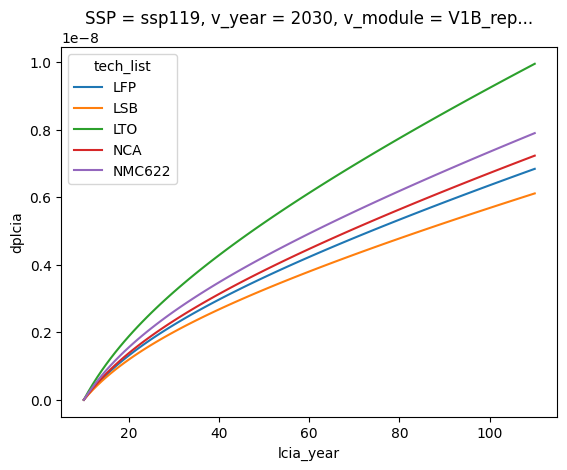

In [18]:
ds.sel(v_year = 2030, v_module = mod_toget, SSP = 'ssp119', dpLCA_IC = 'dpCRF', ensemble = 0 )["dplcia"].plot(x='lcia_year',  hue= 'tech_list'  );

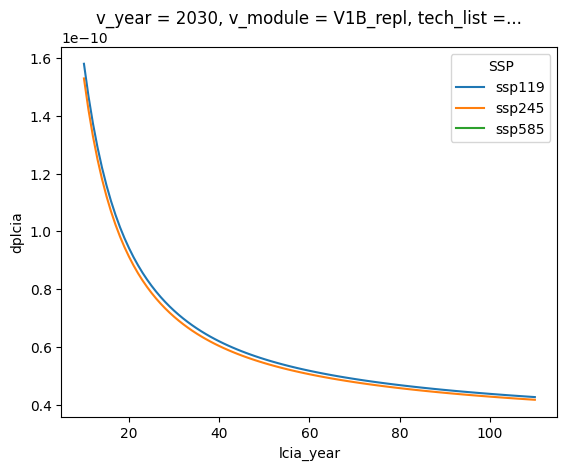

In [19]:
ds.sel(v_year = 2030, v_module = mod_toget, tech_list = 'LSB', dpLCA_IC = 'dpIRF', ensemble = 0 )["dplcia"].plot(x='lcia_year',  hue= 'SSP'  ); 

In [20]:
ds.to_netcdf('../dlcia_output/V1B_BEV_Yrepl_dpIRFCRF.nc')
d1.to_excel('../dlcia_output/excel_perRunYear/V1B_BEV_Yrepl_dpIRFCRF_perYEAR_perTech.xlsx', index = False)